## Keras Tuner

[keras_tuner](https://keras.io/keras_tuner/) supports grid search, random search and Bayesian optimization. It is suited for TensorFlow and, through Keras 3.0, for PyTorch and JAX as well.\
Here we present a random search on the MNIST dataset using a multi-layer perceptron in TensorFlow.

In [1]:
import os; os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # silence tensorflow

import sys; sys.path.append("../") # add repository to path 

import warnings; warnings.filterwarnings("ignore") # suppress warnings

# import libraries for visualization
from IPython.display import display
import matplotlib.pyplot as plt

# set plotting options
%config InlineBackend.figure_format = "svg"
plt.rc("text", usetex=True)
plt.rc("font", family="cm")
plt.rc("axes", grid=False)
plt.rc("ytick", direction="out", color="gray")
plt.rcParams.update({"font.size": 12})

# import package
from par_coords import get_results
from par_coords import plot_par_coords

# import libraries for keras example
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras_tuner.tuners import RandomSearch

# import libraries for sklearn example
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# import libraries for optuna example
import xgboost as xgb
from sklearn.datasets import load_diabetes
import optuna; optuna.logging.set_verbosity(optuna.logging.WARNING) # silence optuna warnings

In [2]:
def build_model(hp):
    """
    Builds a multi-layer perceptron according to hyperparameters specified by the random search.
    """
    model = keras.Sequential()
    model.add(layers.Input(shape=(28, 28)))
    model.add(layers.Flatten())
    # choose the number of units in the hidden layer
    hp_units = hp.Int("units", min_value=32, max_value=512, step=32)
    model.add(layers.Dense(units=hp_units, activation="relu"))
    # final dense layer for classification
    model.add(layers.Dense(10, activation="softmax"))
    # choose the learning rate for the optimizer
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    # compile model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

In [3]:
# load and preprocess the training dataset
mnist = keras.datasets.mnist
(X_train, y_train), _ = mnist.load_data()
X_train = X_train / 255.0

# instantiate the tuner and perform random search
tuner = RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=3, # cross-validation
    directory="../outputs/data/tuning", # results directory
    project_name="mnist_hyperparam_tuning")

tuner.search(X_train, y_train, epochs=5, validation_split=0.2)

Reloading Tuner from ../outputs/data/tuning/mnist_hyperparam_tuning/tuner0.json


In [4]:
results = get_results.keras_tuner(tuner, metric="val_accuracy", num_best_trials=10)
display(results.head())

,units,learning_rate,val_accuracy
0,512,0.0010,0.977139
1,224,0.0010,0.975722
2,160,0.0010,0.974278
3,96,0.0010,0.971556
4,384,0.0001,0.961833


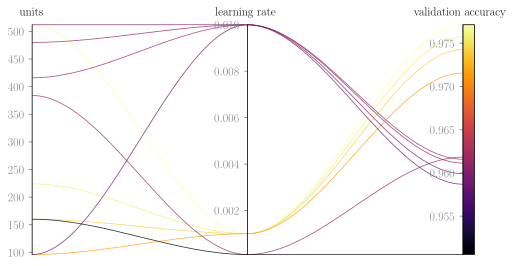

In [5]:
fig = plot_par_coords(results, labels=["units", "learning rate", "validation accuracy"], figsize=(8, 4), 
                      linewidth=0.8, alpha=0.8, cmap=plt.get_cmap("inferno"))
fig.savefig("../outputs/figures/keras_tuner.pdf", dpi=300)

## Scikit-learn

Scikit-learn offers in its `model_selection` module [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) to perform hyperparameter tuning with integrated cross-validation on machine learning models available in sklearn. Below you can find both functions applied to a random forest classifier.

#### GridSearchCV

In [ ]:
# generate some data for binary classification
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# define the parameter grid to search
param_grid = {
    "n_estimators": [100, 200, 300], # number of trees
    "max_depth": [10, 20], # maximum depth for a given tree       
    "min_samples_leaf": [1, 2, 4] # minimum number of samples in a leaf node
}
# initialize the random forest classifier
rf_clf = RandomForestClassifier(random_state=42)
# perform GridSearchCV
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
grid_search.fit(X_train, y_train);

In [ ]:
results = get_results.sklearn(grid_search, "roc_auc")
display(results.head())

In [ ]:
fig = plot_par_coords(results, labels=["maximum tree depth", "minimum samples in leaf node", "number of trees", "area under curve (ROC)"],
                      figsize=(8, 4), curves=False, linewidth=0.8, alpha=0.8, cmap=plt.get_cmap("cividis"))
fig.savefig("../outputs/figures/grid_search.pdf", dpi=300)

#### RandomizedSearchCV

In [ ]:
# define the parameter distributions to sample from
param_dist = {
    'n_estimators': randint(100, 1000), # number of trees
    'max_depth': randint(1, 100, 20), # maximum depth for a given tree
    'min_samples_leaf': randint(1, 20) # minimum number of samples in a leaf node
}
# initialize the random forest classifier
rf_clf = RandomForestClassifier(random_state=42)
# perform RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_clf, param_distributions=param_dist, n_iter=100, cv=5, scoring="f1", n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train);

In [ ]:
results = get_results.sklearn(grid_search, "f1_score")
display(results.head())

In [ ]:
fig = plot_par_coords(results, labels=["maximum tree depth", "minimum samples in leaf node", "number of trees", "F1 score"],
                      figsize=(8, 4), curves=True, linewidth=0.8, alpha=0.8, cmap=plt.get_cmap("copper"))
fig.savefig("../outputs/figures/random_search.pdf", dpi=300)

## Optuna
[Optuna](https://optuna.org/) is powerful framework for hyperparameter tuning compatible with most modern frameworks for machine learning and deep learning. Below you can find an example of Bayesian optimization for the hyperparameters of a gradient boosted tree regressor using the popular [XGBoost](https://xgboost.readthedocs.io/en/stable/) library.

In [ ]:
# load the diabetes dataset from sklearn
diabetes_data = load_diabetes()
# extract features and target variable
X = diabetes_data.data
y = diabetes_data.target
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# cast to xgboost DMatrix for better efficiency (there is also a scikit-learn-like API)
dm_train = xgb.DMatrix(X_train, label=y_train)

In [ ]:
def objective(trial):
    """
    Objective function that takes in a given trial and returns a performance metric to minimize/maximize
    """
    # define the hyperparameters to be tuned
    params = {
        "objective": "reg:squarederror", # squared error loss
        "eval_metric": "rmse", # root mean squared error
        "device": "cuda:0", # GPU integration
        "subsample": 0.8, # fraction of features bootstrapped for a given tree
        "max_depth": trial.suggest_int("max_depth", 1, 12), # maximum tree depth
        "eta": trial.suggest_float("eta", 0.05, 0.5), # regularization
        "gamma": trial.suggest_float("gamma", 0.001, 0.01), # regularization
        "lambda": trial.suggest_float("lambda", 0.1, 5), # regularization
        "alpha": trial.suggest_float("alpha", 0.001, 0.01), # regularization
    }
    # set up cross-validation model
    xgb_cv = xgb.cv(params, dm_train, num_boost_round=2000, nfold=5, early_stopping_rounds=5, verbose_eval=False, as_pandas=True)
    mse = xgb_cv["test-rmse-mean"].min() # best mse encountered
    std = xgb_cv.loc[xgb_cv["test-rmse-mean"].idxmin(), "test-rmse-std"] # corresponding cv error
    # log how many estimators were used (after early stopping) and standard deviation
    trial.set_user_attr("n_estimators", len(xgb_cv))
    trial.set_user_attr("std", std)
    # print update
    print(f"Trial #{trial.number}. Root Mean Squared Error = {mse:.4f} +/- {std:.4f}")
    return mse

In [ ]:
# set up optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

In [ ]:
results = get_results.optuna(study, "mse", ["n_estimators", "std"])
display(results.head())

In [ ]:
fig = plot_par_coords(results, labels=["maximum tree depth", "$\\alpha$", "$\eta$", "$\gamma$", "$\lambda$", "mean squared error"],
                      figsize=(8, 4), curves=True, linewidth=0.8, alpha=0.8, cmap=plt.get_cmap("plasma_r"))
fig.savefig("../outputs/figures/optuna.pdf", dpi=300)